In [48]:
# Install necessary libraries
import json
import pandas as pd
# from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from matplotlib.colors import rgb_to_hsv
from scipy import stats
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

In [49]:
# Mount:
# drive.mount('/content/drive', force_remount = True)

In [50]:
# Read json file
def readJsonData(JSON_FILE_PATH):
  data = None
  try:
    with open(JSON_FILE_PATH, 'r') as f:
        data = json.load(f)
    print("✅ JSON file loaded successfully.")

    metadata = data.get('metadata', {})
    print(f"\n--- Session Metadata ---")
    for key, value in metadata.items():
        print(f"{key.ljust(20)}: {value}")

  except FileNotFoundError:
      print(f"❌ ERROR: File not found at path: {JSON_FILE_PATH}")
      print("Please check the file path and ensure Google Drive is correctly mounted.")
  except json.JSONDecodeError:
      print("❌ ERROR: Could not decode JSON. Ensure the file is valid.")
  return data

# Preprocessing
def preprocessData(data):
  flat_data = []

  # Extract metadata for easy merging later
  session_metadata = data.get('metadata', {})
  session_name = session_metadata.get('sessionName', 'Unknown Session')

  # Iterate through each sample (color card)
  for sample in data.get('data', []):
      sample_number = sample.get('sampleNumber')

      # Iterate through each measurement (1 to 10) within that sample
      for capture_index, measurement in enumerate(sample.get('measurements', [])):

          # Create a dictionary for the current row
          row = {
              'session_name': session_name,
              'sample_number': sample_number,
              'capture_index': capture_index, # 0 to 9
              'lighting_condition': session_metadata.get('lightingCondition'),
              'reflective_surface': session_metadata.get('useReflectiveSurface'),

              # Sensor Data
              'pitch': measurement['angles']['pitch'],
              'roll': measurement['angles']['roll'],
          }

          # Extract Color Data (White and Color reticles, three radii each)

          # White Reticle Captures
          for radius in [0, 2, 4]:
              capture_key = f'r{radius}'
              color_data = measurement['white'].get(capture_key, {'r': 0, 'g': 0, 'b': 0})
              row[f'white_r{radius}_R'] = color_data['r']
              row[f'white_r{radius}_G'] = color_data['g']
              row[f'white_r{radius}_B'] = color_data['b']

          # Color Reticle Captures
          for radius in [0, 2, 4]:
              capture_key = f'r{radius}'
              color_data = measurement['color'].get(capture_key, {'r': 0, 'g': 0, 'b': 0})
              row[f'color_r{radius}_R'] = color_data['r']
              row[f'color_r{radius}_G'] = color_data['g']
              row[f'color_r{radius}_B'] = color_data['b']

          flat_data.append(row)

  # Convert the list of dictionaries to a Pandas DataFrame
  df = pd.DataFrame(flat_data)

  print(f"\n✅ Data flattened into DataFrame with {len(df)} rows (Total captures: 24 samples * 10 captures = 240 rows).")
  return df

# ## 3. Initial Review and Visualization

# Display the first few rows and the column types for verification.
def displayDataFrameInfo(df):
  print("\n--- DataFrame Head (First 5 Rows) ---")
  print(df.head())

  print("\n--- DataFrame Information ---")
  print(df.info())

  # ### 3.1 Check Sensor Variability

  # This checks the pitch/roll stability across all 240 measurements.
  print("\n--- Sensor Angle Statistics ---")
  print(df[['pitch', 'roll']].describe())

In [51]:
def combineGroundTruth(df):
  ground_truth_data = [
      {'sample_number': 1,  'label': 'Dark Skin',      'gt__R': 115, 'gt__G': 82,  'gt__B': 69},
      {'sample_number': 2,  'label': 'Light Skin',     'gt__R': 204, 'gt__G': 161, 'gt__B': 141},
      {'sample_number': 3,  'label': 'Blue Sky',       'gt__R': 101, 'gt__G': 134, 'gt__B': 179},
      {'sample_number': 4,  'label': 'Foliage',        'gt__R': 89,  'gt__G': 109, 'gt__B': 61},
      {'sample_number': 5,  'label': 'Blue Flower',    'gt__R': 141, 'gt__G': 137, 'gt__B': 194},
      {'sample_number': 6,  'label': 'Bluish Green',   'gt__R': 132, 'gt__G': 228, 'gt__B': 208},
      {'sample_number': 7,  'label': 'Orange',         'gt__R': 249, 'gt__G': 118, 'gt__B': 35},
      {'sample_number': 8,  'label': 'Purplish Blue',  'gt__R': 80,  'gt__G': 91,  'gt__B': 182},
      {'sample_number': 9,  'label': 'Moderate Red',   'gt__R': 222, 'gt__G': 91,  'gt__B': 125},
      {'sample_number': 10, 'label': 'Purple',         'gt__R': 91,  'gt__G': 63,  'gt__B': 123},
      {'sample_number': 11, 'label': 'Yellow Green',   'gt__R': 173, 'gt__G': 232, 'gt__B': 91},
      {'sample_number': 12, 'label': 'Orange Yellow',  'gt__R': 255, 'gt__G': 164, 'gt__B': 26},
      {'sample_number': 13, 'label': 'Blue',           'gt__R': 44,  'gt__G': 56,  'gt__B': 142},
      {'sample_number': 14, 'label': 'Green',          'gt__R': 74,  'gt__G': 148, 'gt__B': 81},
      {'sample_number': 15, 'label': 'Red',            'gt__R': 179, 'gt__G': 42,  'gt__B': 50},
      {'sample_number': 16, 'label': 'Yellow',         'gt__R': 250, 'gt__G': 226, 'gt__B': 21},
      {'sample_number': 17, 'label': 'Magenta',        'gt__R': 191, 'gt__G': 81,  'gt__B': 160},
      {'sample_number': 18, 'label': 'Cyan',           'gt__R': 6,   'gt__G': 142, 'gt__B': 172},
      {'sample_number': 19, 'label': 'White',          'gt__R': 252, 'gt__G': 252, 'gt__B': 252},
      {'sample_number': 20, 'label': 'Neutral 8',      'gt__R': 230, 'gt__G': 230, 'gt__B': 230},
      {'sample_number': 21, 'label': 'Neutral 6.5',    'gt__R': 200, 'gt__G': 200, 'gt__B': 200},
      {'sample_number': 22, 'label': 'Neutral 5',      'gt__R': 143, 'gt__G': 143, 'gt__B': 142},
      {'sample_number': 23, 'label': 'Neutral 3.5',    'gt__R': 100, 'gt__G': 100, 'gt__B': 100},
      {'sample_number': 24, 'label': 'Black',          'gt__R': 50,  'gt__G': 50,  'gt__B': 50},
  ]
  df_gt = pd.DataFrame(ground_truth_data)
  df = pd.merge(df, df_gt, on='sample_number', how='outer')

  return df, df_gt

def generateFinalDataFrame(df_with_gt_columns):
  # Calculate average color and corrected color values per sample_number
  avg_cols_to_compute = [
      'color_r0_R', 'color_r0_G', 'color_r0_B',
      'correction_r0_R', 'correction_r0_G', 'correction_r0_B',
      'color_r2_R', 'color_r2_G', 'color_r2_B',
      'correction_r2_R', 'correction_r2_G', 'correction_r2_B',
      'color_r4_R', 'color_r4_G', 'color_r4_B',
      'correction_r4_R', 'correction_r4_G', 'correction_r4_B'
  ]
  df_avg = df_with_gt_columns.groupby('sample_number')[avg_cols_to_compute].mean().reset_index()

  # Rename columns to 'avg_...' to clearly distinguish them
  new_avg_columns_map = {col: 'avg_' + col for col in avg_cols_to_compute}
  df_avg = df_avg.rename(columns=new_avg_columns_map)

  # Merge the df (which now has ground truth) with the averaged color data
  df_final_comparison = pd.merge(df_with_gt_columns, df_avg, on='sample_number', how='left')

  return df_final_comparison

In [52]:
jsonFilePath = 'Data/Zhi2.json'
data = readJsonData(jsonFilePath)
df = preprocessData(data)
df, _ = combineGroundTruth(df)

✅ JSON file loaded successfully.

--- Session Metadata ---
sessionName         : Zhi_02 
lightingCondition   : 5
useReflectiveSurface: True
dateTime            : 2025-11-19T15:47:32.923269

✅ Data flattened into DataFrame with 240 rows (Total captures: 24 samples * 10 captures = 240 rows).


## Method: Using Polynomial Correction, combined with lighting condition:  
1. correction_r2_R = f1(color_r2_R) + gamma1 * lighting
2. correction_r2_G = f2(color_r2_G) + gamma2 * lighting
3. correction_r2_B = f3(color_r2_B) + gamma3 * lighting
## Goal: Learn the coefficients of f1, f2, f3, also gamma1, gamma2, gamma3.
## Continue:

In [53]:
# ============================================================
# Design matrix: polynomial terms + lighting condition
# ============================================================
def build_design_matrix(measured, lighting_vector, degree):
    """
    measured: (N,) measured channel values
    lighting_vector: (N,) 0 = normal, 1 = dark
    degree: polynomial degree

    Returns:
        X: (N, degree + 2)
           [1, x, x^2, ..., x^degree, lighting]
    """
    N = len(measured)
    X_poly = np.vstack([measured**k for k in range(degree + 1)]).T
    lighting_col = lighting_vector.reshape(N, 1)
    X = np.hstack([X_poly, lighting_col])
    return X


# ============================================================
# Loss function (MSE + L2 regularization)
# ============================================================
def regression_loss(theta, X, y, reg_lambda=1e-3):
    """
    theta: regression coefficients
    X: design matrix
    y: ground truth
    """
    y_pred = X @ theta
    mse = mean_squared_error(y, y_pred)
    reg = reg_lambda * np.sum(theta**2)
    return mse + reg


# ============================================================
# Optimize one color channel
# ============================================================
def fit_single_channel(measured, gt, lighting_vector, degree):
    """
    Fit polynomial + lighting model for one RGB channel
    """
    X = build_design_matrix(measured, lighting_vector, degree)

    # initial guess
    theta0 = np.zeros(X.shape[1])
    theta0[1] = 1.0  # roughly identity mapping

    result = minimize(
        regression_loss,
        theta0,
        args=(X, gt),
        method="L-BFGS-B"
    )
    return {
        "theta": result.x,
        "success": result.success,
        "final_mse": mean_squared_error(gt, X @ result.x)
    }


In [54]:
def fit_rgb_polynomial_with_lighting(
    df,
    degree,
    lighting_col="lighting",
    meas_prefix="color_r4_",
    gt_prefix="gt__"
):
    """
    Fit polynomial + lighting regression for RGB channels.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe
    degree : int
        Polynomial degree
    lighting_col : str
        Column name for lighting condition (0=normal, 1=dark)
    meas_prefix : str
        Prefix for measured RGB columns
    gt_prefix : str
        Prefix for ground truth RGB columns

    Returns
    -------
    results : dict
        results[channel] contains:
            - theta
            - success
            - final_mse
    """
    lighting_vector = df[lighting_col].values
    results = {}

    for ch in ["R", "G", "B"]:
        measured = df[f"{meas_prefix}{ch}"].values
        gt = df[f"{gt_prefix}{ch}"].values

        results[ch] = fit_single_channel(
            measured=measured,
            gt=gt,
            lighting_vector=lighting_vector,
            degree=degree
        )
    return results


In [55]:
def correctByFixedWhiteScaling(ref_r, ref_g, ref_b, meas_r, meas_g, meas_b):
  # Apply scaling correction based on a fixed white reference
  scale_r = 255.0 / (ref_r if ref_r > 0 else 1.0)
  scale_g = 255.0 / (ref_g if ref_g > 0 else 1.0)
  scale_b = 255.0 / (ref_b if ref_b > 0 else 1.0)

  corr_r = np.clip(meas_r * scale_r, 0, 255).astype(int)
  corr_g = np.clip(meas_g * scale_g, 0, 255).astype(int)
  corr_b = np.clip(meas_b * scale_b, 0, 255).astype(int)
  return corr_r, corr_g, corr_b

def correctByPolynomial(meas_val, coeffs, lighting=None):
  coeffs = np.asarray(coeffs)

  # Separate polynomial and lighting coefficient
  if lighting is None:
      poly_coeffs = coeffs
      gamma = 0.0
  else:
      poly_coeffs = coeffs[:-1]
      gamma = coeffs[-1]

  # Polynomial part
  corr_val = 0.0
  for k, b in enumerate(poly_coeffs):
      corr_val += b * (meas_val ** k)

  # Lighting term
  corr_val += gamma * lighting

  return corr_val

from functools import partial

# This function will be passed to df.apply and dispatches to the correct method
def apply_correction_dispatcher(row, color_prefix, radius, correction_type, lighting=None, coeffs_R=None, coeffs_G=None, coeffs_B=None, ref_white_R=None, ref_white_G=None, ref_white_B=None):
    meas_r = row[f'{color_prefix}_R']
    meas_g = row[f'{color_prefix}_G']
    meas_b = row[f'{color_prefix}_B']

    if correction_type == 'white_scaling':
        # Use the fixed white reference for scaling
        ref_r = 184.5 # Default from original apply_correction
        ref_g = 171.8
        ref_b = 146.5
        corr_r, corr_g, corr_b = correctByFixedWhiteScaling(ref_r, ref_g, ref_b, meas_r, meas_g, meas_b)
    elif correction_type == 'polynomial':
        corr_r = correctByPolynomial(meas_r, coeffs_R, lighting)
        corr_g = correctByPolynomial(meas_g, coeffs_G, lighting)
        corr_b = correctByPolynomial(meas_b, coeffs_B, lighting)
        # Apply clipping here as correctByPolynomial doesn't do it
        corr_r = np.clip(corr_r, 0, 255).astype(int)
        corr_g = np.clip(corr_g, 0, 255).astype(int)
        corr_b = np.clip(corr_b, 0, 255).astype(int)
    else:
        raise ValueError(f"Unknown correction_type: {correction_type}")

    return pd.Series([corr_r, corr_g, corr_b])

# Main function to apply corrections to DataFrame
def correctRGB(df, correction_type, lighting=None, coeffs_R=None, coeffs_G=None, coeffs_B=None):
  # partial the dispatcher so we can pass the specific correction_type and coeffs
  partial_apply = partial(
      apply_correction_dispatcher,
      correction_type=correction_type,
      lighting=lighting,
      coeffs_R=coeffs_R,
      coeffs_G=coeffs_G,
      coeffs_B=coeffs_B
  )

  df[['correction_r0_R', 'correction_r0_G', 'correction_r0_B']] = df.apply(
    lambda row: partial_apply(row, 'color_r0', radius=0), axis=1
  ).clip(0, 255)

  df[['correction_r2_R', 'correction_r2_G', 'correction_r2_B']] = df.apply(
    lambda row: partial_apply(row, 'color_r2', radius=2), axis=1
  ).clip(0, 255)

  df[['correction_r4_R', 'correction_r4_G', 'correction_r4_B']] = df.apply(
    lambda row: partial_apply(row, 'color_r4', radius=4), axis=1
  ).clip(0, 255)


print("Correction functions redefined for flexibility.")

Correction functions redefined for flexibility.


In [ ]:
# First using one dataset for both training and testing
# Dark room value: 1
lighting_condition = 1
df["lighting"] = lighting_condition

best_result = fit_rgb_polynomial_with_lighting(df, degree=3)

best_coeffs_R = best_result["R"]["theta"]
best_coeffs_G = best_result["G"]["theta"]
best_coeffs_B = best_result["B"]["theta"]
correctRGB(df, correction_type='polynomial', lighting=lighting_condition, coeffs_R=best_coeffs_R, coeffs_G=best_coeffs_G, coeffs_B=best_coeffs_B)

def rgb_to_hsv_wrapper(r, g, b):
    # Normalize RGB values to [0, 1]
    rgb_normalized = np.array([r, g, b]) / 255.0
    h, s, v = rgb_to_hsv(rgb_normalized)
    return pd.Series([h, s, v])

# Convert original RGB values to HSV and add to DataFrame
rgb_column_sets = [
    ('white', 'r0'), ('white', 'r2'), ('white', 'r4'),
    ('color', 'r0'), ('color', 'r2'), ('color', 'r4'),
    ('gt', '') # This entry needs to be fixed to match the new gt__R naming
]

for prefix, radius in rgb_column_sets:
    # Special handling for ground truth to match the double underscore naming
    if prefix == 'gt':
        r_col, g_col, b_col = 'gt__R', 'gt__G', 'gt__B'
        h_col, s_col, v_col = 'gt__H', 'gt__S', 'gt__V'
    else:
        r_col, g_col, b_col = f'{prefix}_{radius}_R', f'{prefix}_{radius}_G', f'{prefix}_{radius}_B'
        h_col, s_col, v_col = f'{prefix}_{radius}_H', f'{prefix}_{radius}_S', f'{prefix}_{radius}_V'

    df[[h_col, s_col, v_col]] = df.apply(
        lambda row: rgb_to_hsv_wrapper(row[r_col], row[g_col], row[b_col]),
        axis=1, result_type='expand'
    )
displayDataFrameInfo(df)


--- DataFrame Head (First 5 Rows) ---
  session_name  sample_number  capture_index  lighting_condition  \
0      Zhi_02               1              0                   5   
1      Zhi_02               1              1                   5   
2      Zhi_02               1              2                   5   
3      Zhi_02               1              3                   5   
4      Zhi_02               1              4                   5   

   reflective_surface     pitch      roll  white_r0_R  white_r0_G  white_r0_B  \
0                True  0.010685  3.682334          69          65          62   
1                True  0.020973  3.982072          67          66          62   
2                True  0.221880  3.626029          69          65          62   
3                True  0.227399  3.601382          67          66          64   
4                True  0.285101  3.618525          68          64          61   

   ...  color_r0_V  color_r2_H  color_r2_S  color_r2_V  color_r4_

In [57]:
df_final_comparison = generateFinalDataFrame(df)
displayDataFrameInfo(df_final_comparison)


--- DataFrame Head (First 5 Rows) ---
  session_name  sample_number  capture_index  lighting_condition  \
0      Zhi_02               1              0                   5   
1      Zhi_02               1              1                   5   
2      Zhi_02               1              2                   5   
3      Zhi_02               1              3                   5   
4      Zhi_02               1              4                   5   

   reflective_surface     pitch      roll  white_r0_R  white_r0_G  white_r0_B  \
0                True  0.010685  3.682334          69          65          62   
1                True  0.020973  3.982072          67          66          62   
2                True  0.221880  3.626029          69          65          62   
3                True  0.227399  3.601382          67          66          64   
4                True  0.285101  3.618525          68          64          61   

   ...  avg_color_r2_B  avg_correction_r2_R  avg_correction_r2_G 

In [58]:
df_final_comparison[['gt__R', 'gt__G', 'gt__B']]

,gt__R,gt__G,gt__B
0,115,82,69
1,115,82,69
2,115,82,69
3,115,82,69
4,115,82,69
...,...,...,...
235,50,50,50
236,50,50,50
237,50,50,50
238,50,50,50


In [59]:
df_final_comparison[['color_r4_R', 'color_r4_G', 'color_r4_B']]

,color_r4_R,color_r4_G,color_r4_B
0,22,17,13
1,22,17,12
2,23,18,13
3,23,17,13
4,23,17,13
...,...,...,...
235,9,9,9
236,10,10,10
237,9,9,7
238,9,9,9


In [60]:
df_final_comparison[['correction_r4_R', 'correction_r4_G', 'correction_r4_B']]

,correction_r4_R,correction_r4_G,correction_r4_B
0,129,91,86
1,129,91,79
2,134,95,86
3,134,91,86
4,134,91,86
...,...,...,...
235,54,50,58
236,61,55,65
237,54,50,42
238,54,50,58


In [61]:
a_sum_sq = ((df_final_comparison['gt__R'] - df_final_comparison['correction_r4_R']) ** 2).sum()
b_sum_sq = ((df_final_comparison['gt__G'] - df_final_comparison['correction_r4_G']) ** 2).sum()
c_sum_sq = ((df_final_comparison['gt__B'] - df_final_comparison['correction_r4_B']) ** 2).sum()

print(f"Sum of (a1 - a2)^2: {a_sum_sq}")
print(f"Sum of (b1 - b2)^2: {b_sum_sq}")
print(f"Sum of (c1 - c2)^2: {c_sum_sq}")

Sum of (a1 - a2)^2: 57290
Sum of (b1 - b2)^2: 49860
Sum of (c1 - c2)^2: 99863


In [62]:
def rgb_to_hsv_overload(r, g, b):
    # Normalize R, G, B values to the range 0-1
    r_norm, g_norm, b_norm = map(lambda x: x/255, (r,g,b))

    # Calculate C_max, C_min, and delta
    C_max, C_min = max(r_norm, g_norm, b_norm), min(r_norm, g_norm, b_norm)
    delta = C_max - C_min

    # Calculate Hue (H)
    h = 0
    if delta > 0:
      if C_max == r_norm: h = 60 * (((g_norm - b_norm) / delta) % 6)
      elif C_max == g_norm: h = 60 * (((b_norm - r_norm) / delta) + 2)
      elif C_max == b_norm: h = 60 * (((r_norm - g_norm) / delta) + 4)

    # Ensure H is in the range [0, 360)
    if h < 0: h += 360

    # Calculate Saturation (S)
    s = delta / C_max if C_max > 0 else 0

    # Calculate Value (V)
    v = C_max

    return h, s, v

def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(int(r), int(g), int(b))

In [63]:
def plot_comparison_grid(df_final_comparison, radius, rows=6, cols=4):
    df_plot = df_final_comparison.drop_duplicates(subset=['sample_number']).reset_index(drop=True)

    num_samples = len(df_plot)
    print(f"Plotting {num_samples} unique samples for radius r{radius}.")

    if num_samples == 0:
        print(f"No data to plot for radius r{radius}.")
        return

    if num_samples != rows * cols:
        print(f"Warning: Number of samples ({num_samples}) does not match grid size ({rows}x{cols}). Plotting up to {rows * cols} samples.")

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.flatten()

    for i, row_data in df_plot.iterrows():
        if i >= len(axes):
            break # Stop if we run out of subplots

        # Dynamically extract columns based on radius, now using the 'avg_' prefix for comparison plots
        uncorr_r, uncorr_g, uncorr_b = row_data[f'avg_color_r{radius}_R'], row_data[f'avg_color_r{radius}_G'], row_data[f'avg_color_r{radius}_B']
        corr_r, corr_g, corr_b = row_data[f'avg_correction_r{radius}_R'], row_data[f'avg_correction_r{radius}_G'], row_data[f'avg_correction_r{radius}_B']

        # Ground Truth remains the same
        gt_r, gt_g, gt_b = row_data['gt__R'], row_data['gt__G'], row_data['gt__B']
        label = row_data['label']
        sample_number = row_data['sample_number']

        # Normalize RGB values to 0-1 for imshow
        gt_color_norm = np.array([gt_r, gt_g, gt_b]) / 255.0
        uncorr_color_norm = np.array([uncorr_r, uncorr_g, uncorr_b]) / 255.0
        corr_color_norm = np.array([corr_r, corr_g, corr_b]) / 255.0

        # Create the 100x100 image array for the 3-part comparison
        image = np.zeros((100, 100, 3))

        # Lower half (Ground Truth)
        image[50:100, 0:100] = gt_color_norm
        # Upper-left quarter (Uncorrected)
        image[0:50, 0:50] = uncorr_color_norm
        # Upper-right quarter (Corrected)
        image[0:50, 50:100] = corr_color_norm

        ax = axes[i]
        ax.imshow(image)

        # Add hex labels
        ax.text(25, 75, rgb_to_hex(gt_r, gt_g, gt_b), color='black' if np.mean(gt_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
        ax.text(25, 25, rgb_to_hex(uncorr_r, uncorr_g, uncorr_b), color='black' if np.mean(uncorr_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
        ax.text(75, 25, rgb_to_hex(corr_r, corr_g, corr_b), color='black' if np.mean(corr_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

        ax.set_title(f"#{int(sample_number)}: {label}", fontsize=9)
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide any unused subplots
    for j in range(num_samples, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f'R{radius} Comparison (Averaged): Ground Truth vs. Uncorrected vs. Corrected', y=0.98, fontsize=16)
    if radius == 0: plt.savefig('Correction comparison with ground truth.png')
    plt.show()

def plotAllRadius(df_final_comparison):
  for radius in [0, 2, 4]:
    plot_comparison_grid(df_final_comparison, radius)

Plotting 24 unique samples for radius r0.


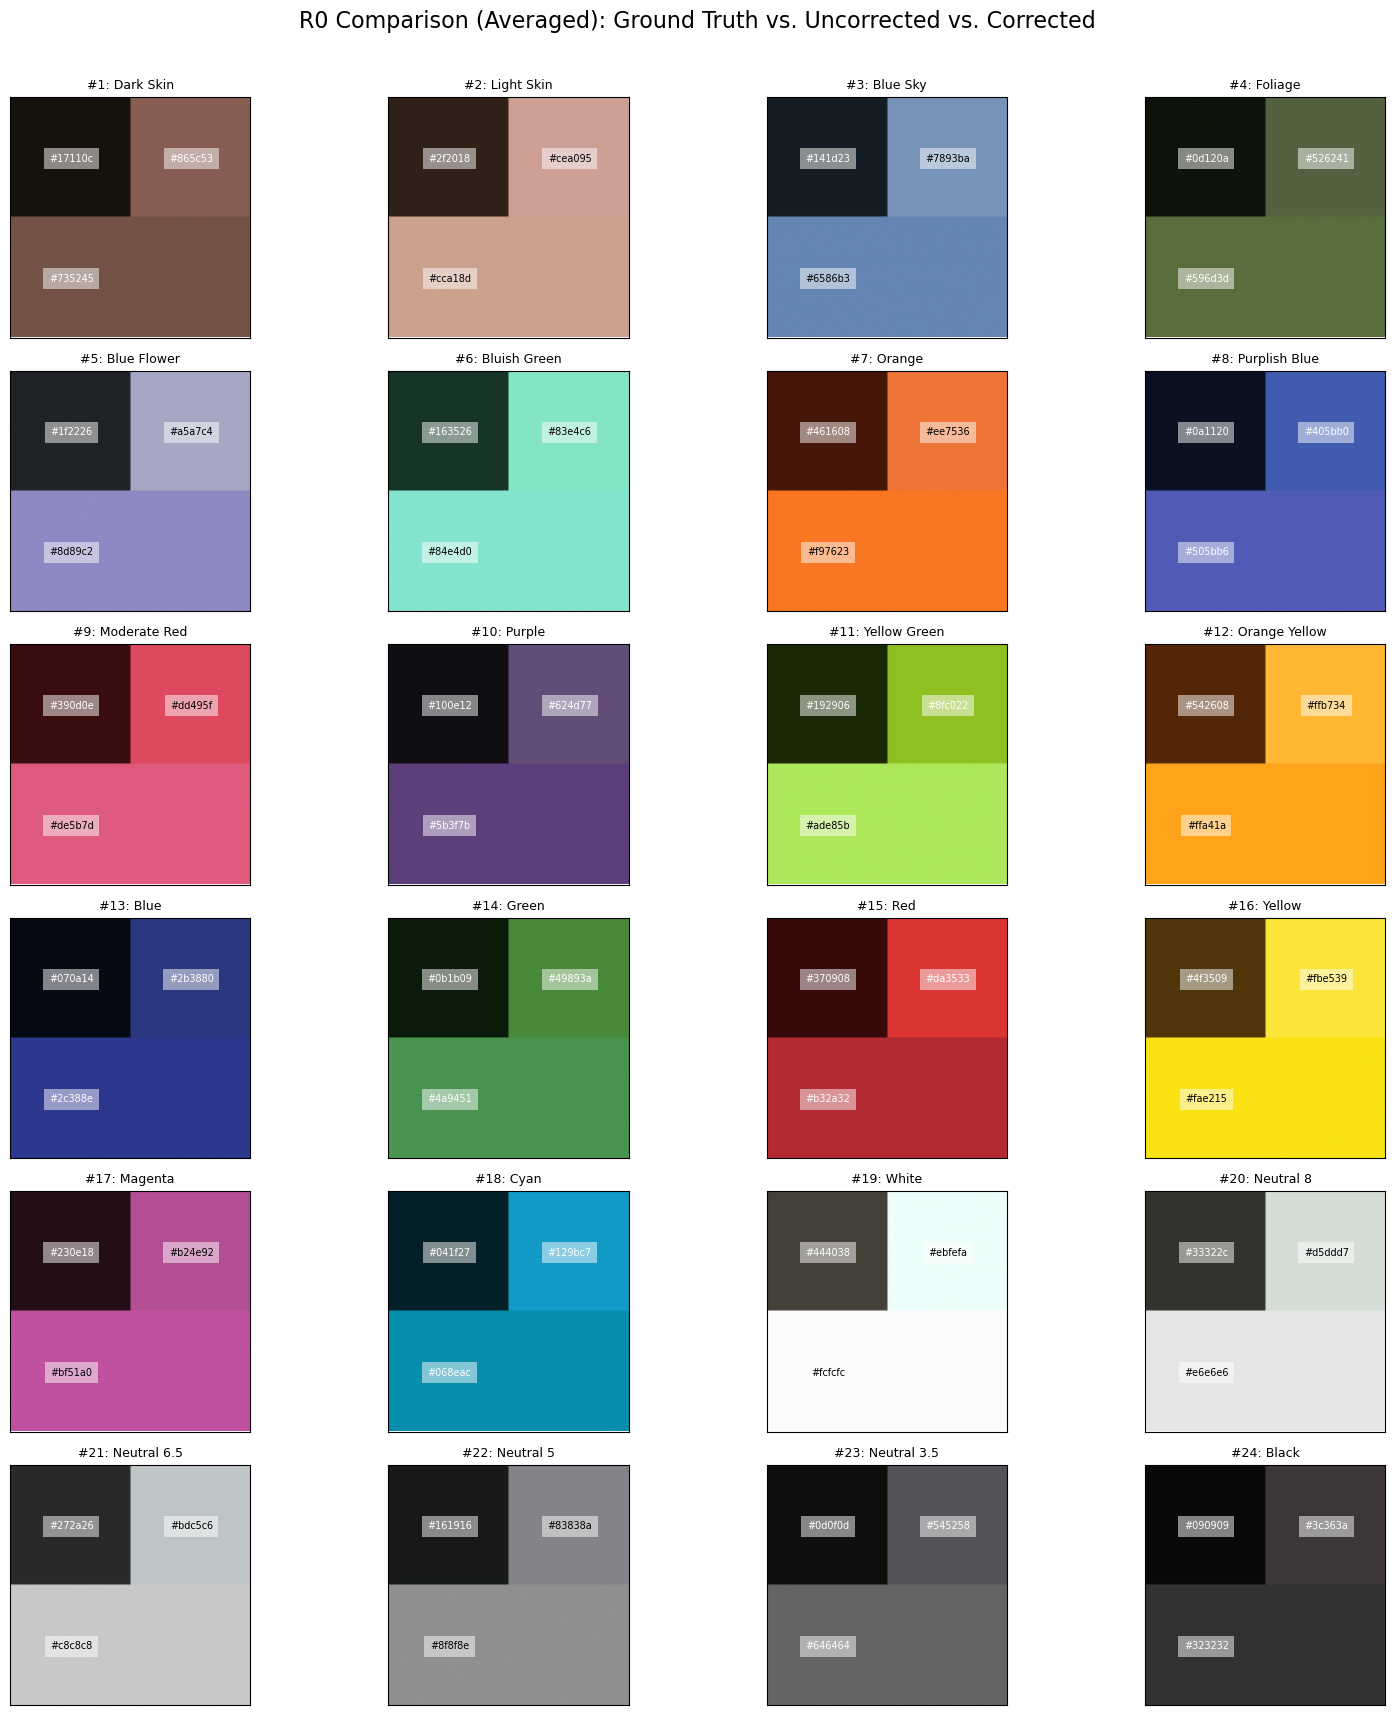

Plotting 24 unique samples for radius r2.


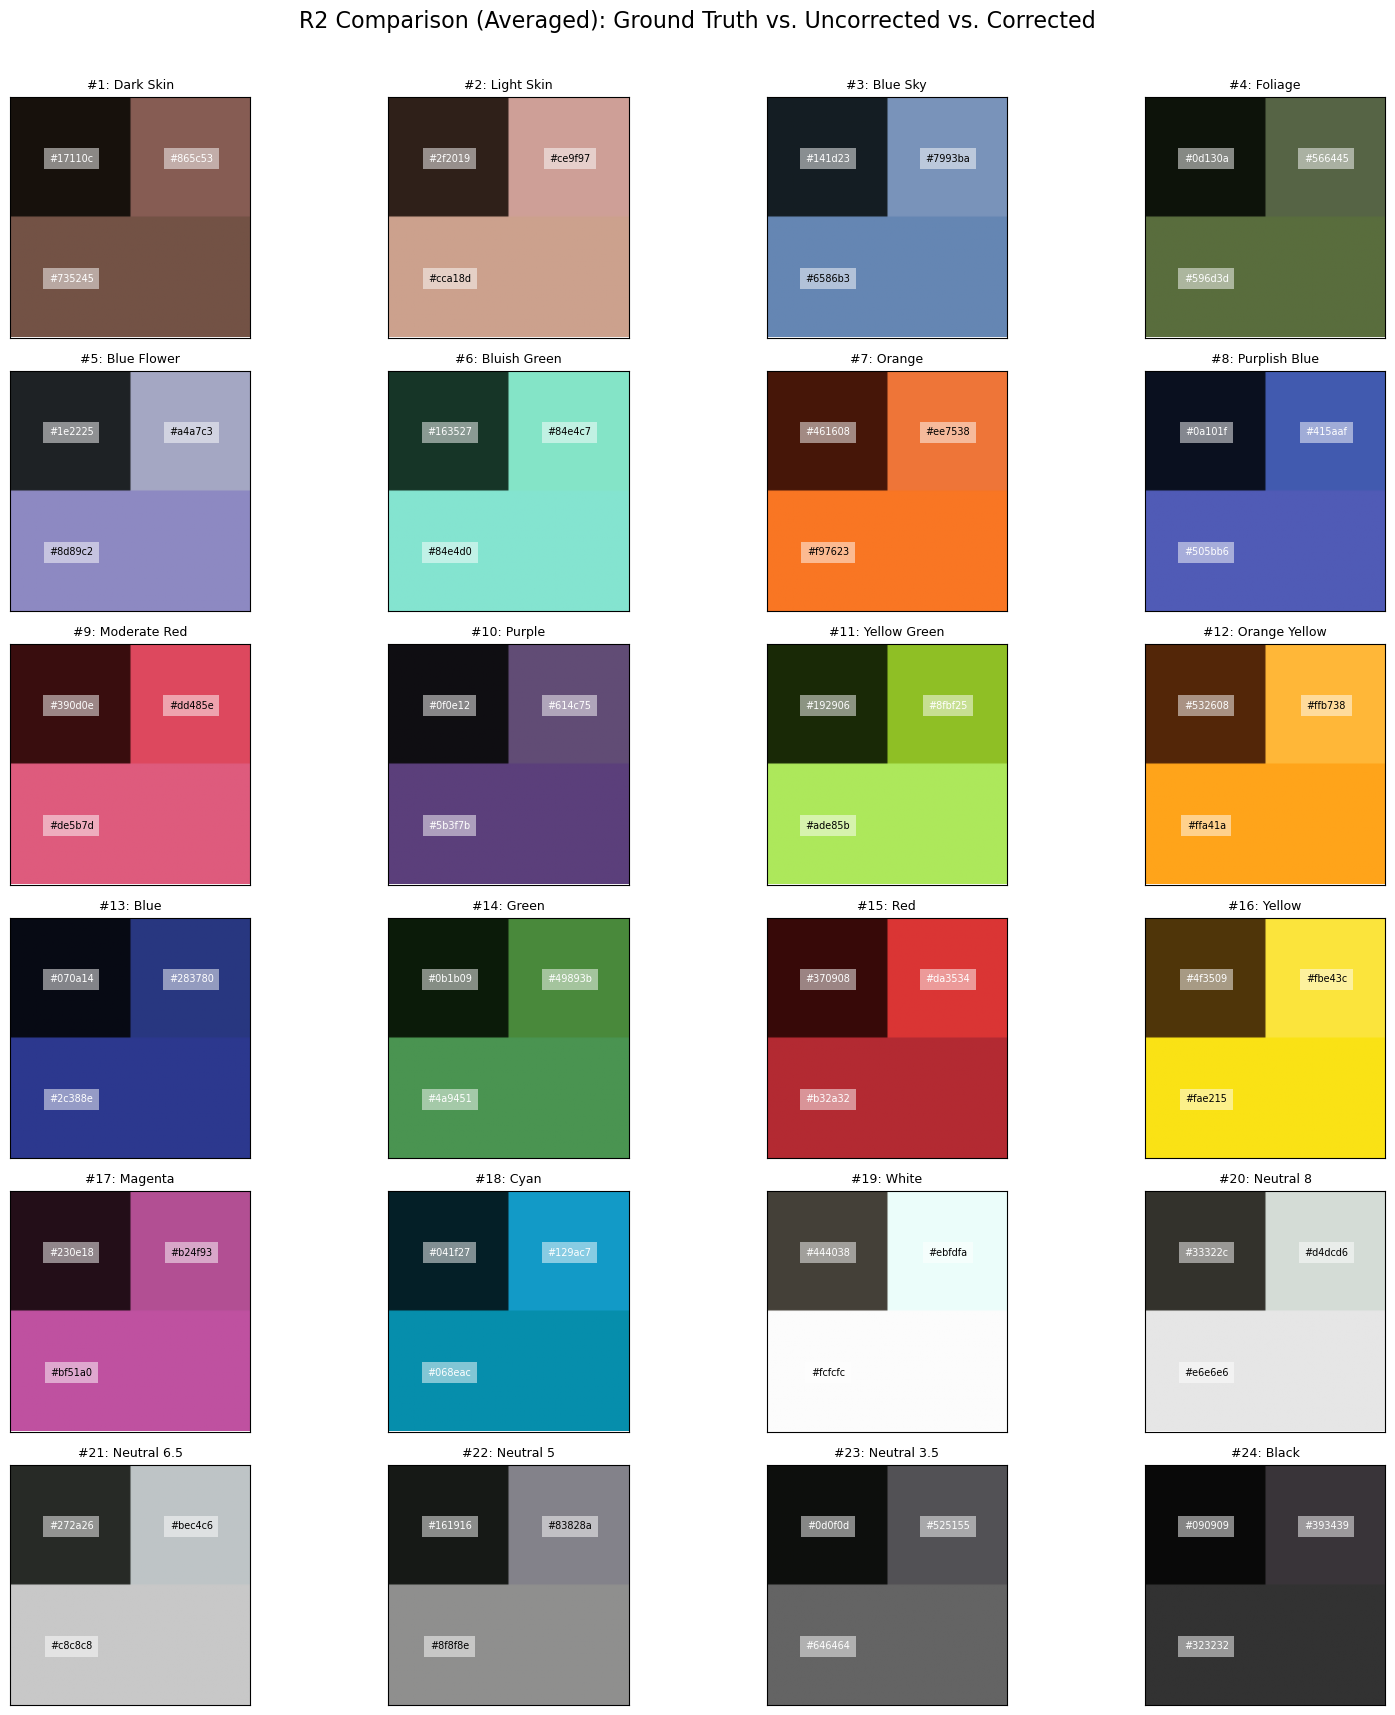

Plotting 24 unique samples for radius r4.


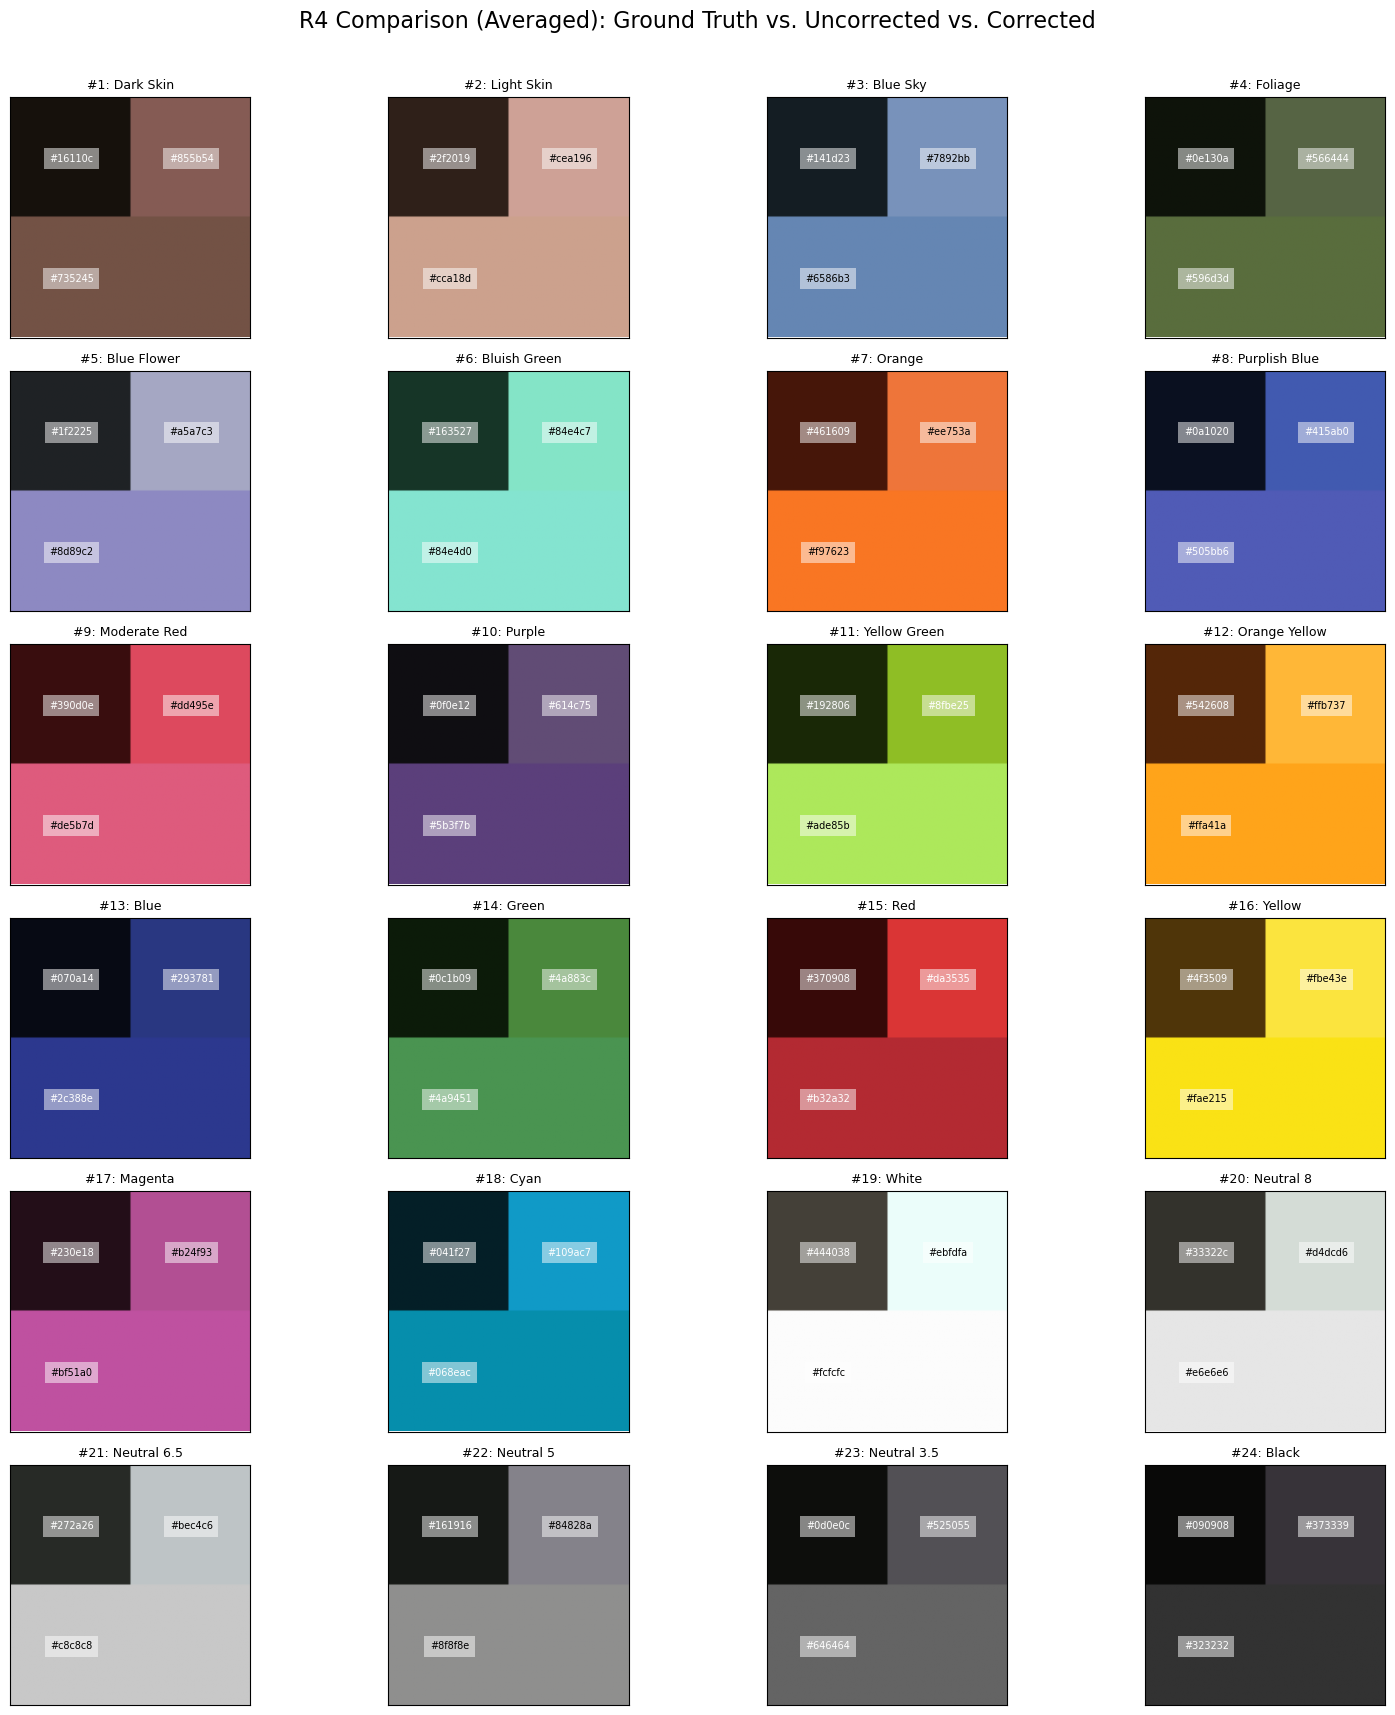

In [64]:
plotAllRadius(df_final_comparison)
# Not visually clear for human's eyes. But the MSE has decreased. A meticulous analysis would yield this is better.

In [65]:
def convert_rgb_to_hsv(r, g, b):
    # Normalize RGB values to 0-1 range
    normalized_rgb = np.array([r, g, b]) / 255.0
    # Convert to HSV
    hsv = rgb_to_hsv(normalized_rgb)
    return hsv[0], hsv[1], hsv[2]

# Apply to Ground Truth colors
def df_HSV(df_final_comparison):
  df_final_comparison[['gt__H', 'gt__S', 'gt__V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['gt__R'], row['gt__G'], row['gt__B']),
      axis=1,
      result_type='expand'
  )

  # Apply to Uncorrected colors
  df_final_comparison[['uncorr_H', 'uncorr_S', 'uncorr_V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['color_r2_R'], row['color_r2_G'], row['color_r2_B']),
      axis=1,
      result_type='expand'
  )

  # Apply to Corrected colors
  df_final_comparison[['corr_H', 'corr_S', 'corr_V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['correction_r2_R'], row['correction_r2_G'], row['correction_r2_B']),
      axis=1,
      result_type='expand'
  )

  # Calculate H_error considering the circular nature of Hue (normalized to 0-1)
  h_diff_uncorr = np.abs(df_final_comparison['uncorr_H'] - df_final_comparison['gt__H'])
  df_final_comparison['H_error_uncorr'] = np.minimum(h_diff_uncorr, 1 - h_diff_uncorr)

  h_diff_corr = np.abs(df_final_comparison['corr_H'] - df_final_comparison['gt__H'])
  df_final_comparison['H_error_corr'] = np.minimum(h_diff_corr, 1 - h_diff_corr)

  df_final_comparison['S_error_uncorr'] = df_final_comparison['uncorr_S'] - df_final_comparison['gt__S']
  df_final_comparison['S_error_corr'] = df_final_comparison['corr_S'] - df_final_comparison['gt__S']

  df_final_comparison['V_error_uncorr'] = df_final_comparison['uncorr_V'] - df_final_comparison['gt__V']
  df_final_comparison['V_error_corr'] = df_final_comparison['corr_V'] - df_final_comparison['gt__V']
  return df_final_comparison

In [66]:
# Define the HSV components to plot
def plotHSV(df_final_comparison):
  hsv_components = ['H', 'S', 'V']

  for component in hsv_components:
      plt.figure(figsize=(10, 6))

      # Uncorrected error column name
      uncorr_error_col = f'{component}_error_uncorr'
      # Corrected error column name
      corr_error_col = f'{component}_error_corr'

      # Plot uncorrected error distribution
      sns.kdeplot(x=df_final_comparison[uncorr_error_col],
              fill=True,
              color='blue',
              label='Uncorrected',
              alpha=0.2,
              common_norm=False)

      # Plot corrected error distribution
      #sns.histplot(df_final_comparison[corr_error_col], kde=True, color='red', label='Corrected', alpha=0.6, stat='density', common_norm=False)

      sns.kdeplot(x=df_final_comparison[corr_error_col],
              fill=True,
              color='red',
              label='Corrected',
              alpha=0.2,
              common_norm=False)

      # Calculate mean and standard deviation for both distributions
      mean_uncorr = df_final_comparison[uncorr_error_col].mean()
      std_uncorr = df_final_comparison[uncorr_error_col].std()

      mean_corr = df_final_comparison[corr_error_col].mean()
      std_corr = df_final_comparison[corr_error_col].std()

      # Add text annotations for mean and std dev
      plt.axvline(mean_uncorr, color='blue', linestyle='dashed', linewidth=1)
      plt.text(mean_uncorr + 0.01, plt.ylim()[1]*0.9, f'Mean Uncorr: {mean_uncorr:.3f}', color='blue', fontsize=10)
      plt.text(mean_uncorr + 0.01, plt.ylim()[1]*0.85, f'Std Uncorr: {std_uncorr:.3f}', color='blue', fontsize=10)

      plt.axvline(mean_corr, color='red', linestyle='dashed', linewidth=1)
      plt.text(mean_corr + 0.01, plt.ylim()[1]*0.75, f'Mean Corr: {mean_corr:.3f}', color='red', fontsize=10)
      plt.text(mean_corr + 0.01, plt.ylim()[1]*0.7, f'Std Corr: {std_corr:.3f}', color='red', fontsize=10)

      # Set title and labels
      plt.title(f'Distribution of {component} Error: Uncorrected vs. Corrected')
      plt.xlabel('Error Value')
      plt.ylabel('Density')
      plt.legend()
      plt.grid(True, linestyle='--', alpha=0.7)
      plt.tight_layout()
      plt.show()


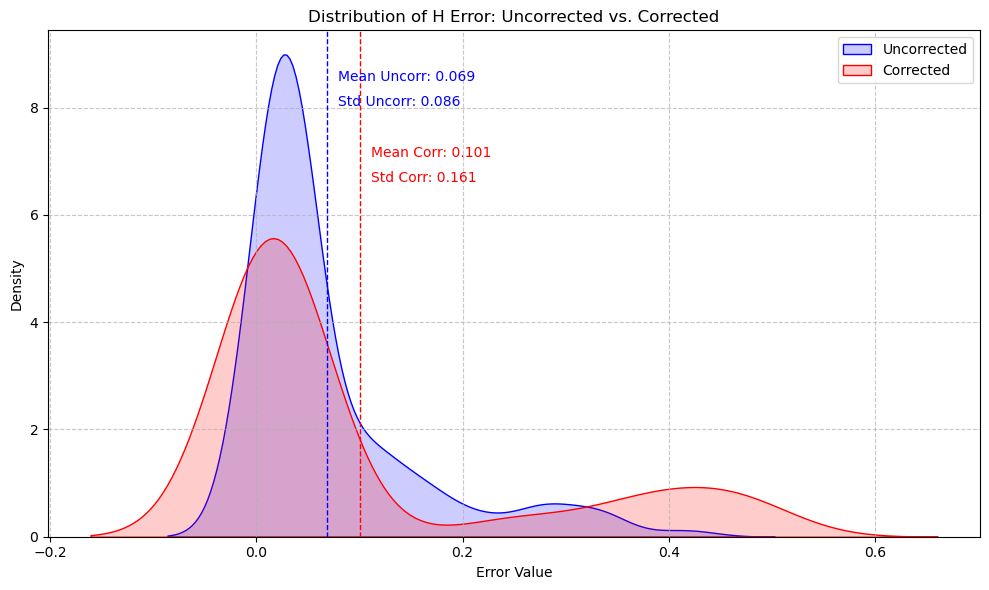

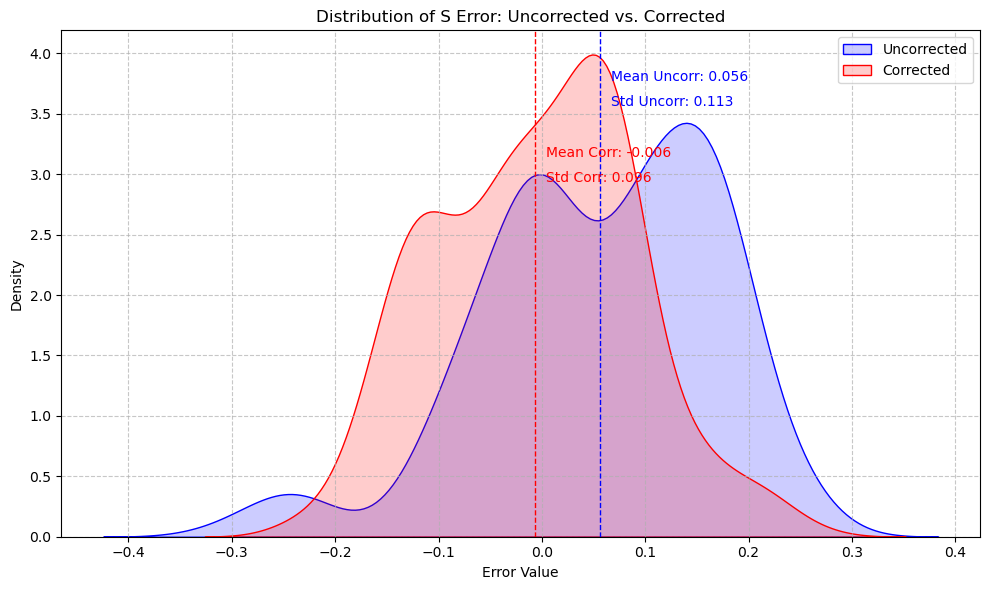

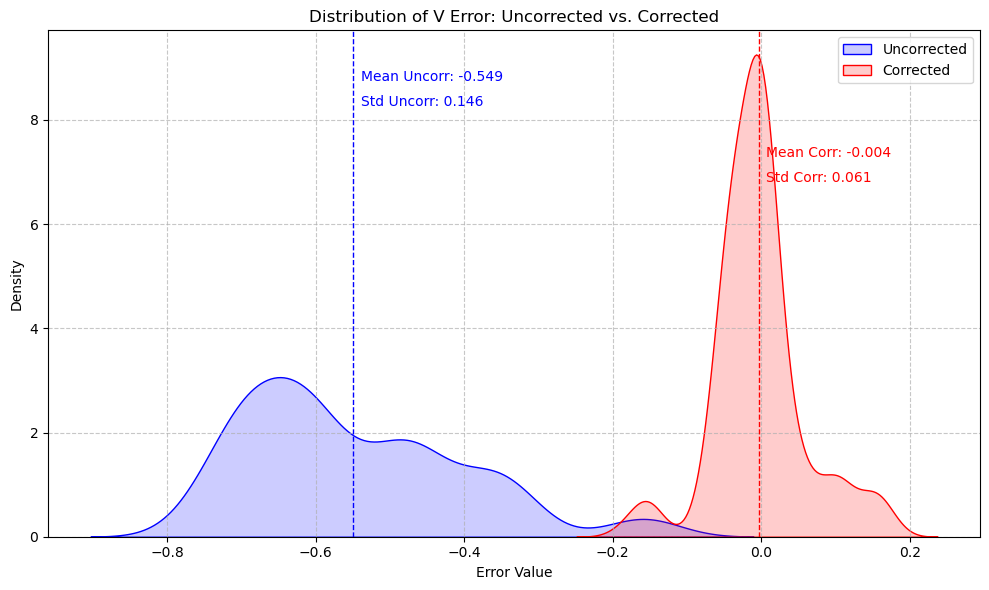

In [67]:
df = df_HSV(df)
plotHSV(df)

In [68]:
ref_r_white = 184.5
ref_g_white = 171.8
ref_b_white = 146.5

# Apply the correction to the color_r4 values
corrected_r_white_scaling, corrected_g_white_scaling, corrected_b_white_scaling = correctByFixedWhiteScaling(
    ref_r_white, ref_g_white, ref_b_white,
    df['color_r4_R'].values,
    df['color_r4_G'].values,
    df['color_r4_B'].values
)

# Calculate MSE for each channel
mse_r_white_scaling = mean_squared_error(df['gt__R'].values, corrected_r_white_scaling)
mse_g_white_scaling = mean_squared_error(df['gt__G'].values, corrected_g_white_scaling)
mse_b_white_scaling = mean_squared_error(df['gt__B'].values, corrected_b_white_scaling)

# Calculate average MSE
avg_mse_white_scaling = (mse_r_white_scaling + mse_g_white_scaling + mse_b_white_scaling) / 3

print("Fixed White Scaling MSE:")
print(f"  R Channel MSE: {mse_r_white_scaling:.2f}")
print(f"  G Channel MSE: {mse_g_white_scaling:.2f}")
print(f"  B Channel MSE: {mse_b_white_scaling:.2f}")
print(f"  Average MSE: {avg_mse_white_scaling:.2f}")


print("\nPolynomial Combined Lighting Correction MSE:")
print(f"  R Channel MSE: {best_result['R']['final_mse']:.2f}")
print(f"  G Channel MSE: {best_result['G']['final_mse']:.2f}")
print(f"  B Channel MSE: {best_result['B']['final_mse']:.2f}")
print(f"  Average MSE: {(best_result['R']['final_mse']+best_result['G']['final_mse']+best_result['B']['final_mse'])/3:.2f}")

Fixed White Scaling MSE:
  R Channel MSE: 12338.68
  G Channel MSE: 10644.10
  B Channel MSE: 9595.63
  Average MSE: 10859.47

Polynomial Combined Lighting Correction MSE:
  R Channel MSE: 240.91
  G Channel MSE: 207.77
  B Channel MSE: 414.47
  Average MSE: 287.72
